Parte 2: Avalie seus resultados gerando uma curva ROC e calculando sua área.

Parte 3: Avalie a robustez do seu resultado redefinindo randomicamente os samples de treinamento e teste pelo menos 10-20 vezes e calculando o desvio padrão e a média da curva.

Parte 4: Avalie o overfitting da sua rede.

Parte 5: Adicione mais um bloco Conv+ReLu+Maxpool e refaça o passo 3. O resultado melhorou ou piorou? Você consegue obter alguma intuição desse resultado?

https://bitbucket.org/kognitalab/images_mini_challange/src/master/

In [1]:
pip install unrar


In [2]:
!unrar x '/content/drive/My Drive/Colab Notebooks/DL/Ex_4/data_folder.rar' 


A saída de streaming foi truncada nas últimas 5000 linhas.
Extracting  data_folder/6925520079_37f660b9ba.jpg                         60%  OK 
Extracting  data_folder/6929597574_dc5dd8b10b.jpg                         60%  OK 
Extracting  data_folder/6931532444_f3f1db0b6e.jpg                         60%  OK 
Extracting  data_folder/6938682540_7697a17902.jpg                         60%  OK 
Extracting  data_folder/6938683414_07c2935433.jpg                         60%  OK 
Extracting  data_folder/6938684226_d38a72c32d.jpg                         60%  OK 
Extracting  data_folder/6938688566_4a72e848f7.jpg                         60%  OK 
Extracting  data_folder/6938696766_abb5dd7907.jpg                         60%  OK 
Extracting  data_folder/6938697544_ea0a40b970.jpg                         60%  OK 
Extracting  data_folder/6938704602_024838879c.jpg                         60%  OK 
Extracting  data_fold

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import time


In [4]:
folder = '/content/data_folder'
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DL/Ex_4/dataset_images_minitest.csv',delimiter="\t", encoding = 'unicode_escape')


# **Spliting dataframe between train and test datasets**

Classes frequency:

In [ ]:
df['category'].hist()
plt.title('Classes Distribution')
plt.show()

Spliting between train and validation dataframes:

In [218]:
from sklearn.model_selection import train_test_split

X = df['filename']
y = df['category']

X_, X_test, y_, y_test = train_test_split(X,
                                          y, 
                                          stratify=y, 
                                          test_size=0.2, 
                                          )

X_train, X_val, y_train, y_val = train_test_split(X_,
                                                  y_, 
                                                  stratify=y_, 
                                                  test_size=0.3, 
                                                  )


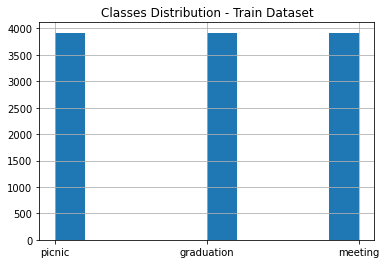

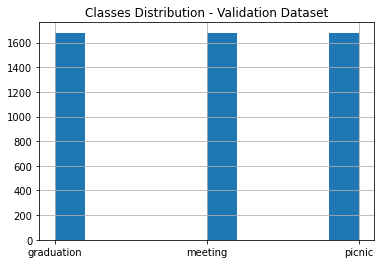

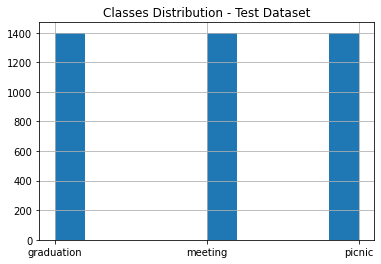

In [219]:
y_train.hist()
plt.title('Classes Distribution - Train Dataset')
plt.show()

y_val.hist()
plt.title('Classes Distribution - Validation Dataset')
plt.show()

y_test.hist()
plt.title('Classes Distribution - Test Dataset')
plt.show()

Evaluate if there is a balanced distribution classes on the datasets:

In [220]:
print(f"\nTrain Dataset:\n{y_train.value_counts()}")
print(f"\nValidation Dataset:\n{y_val.value_counts()}")
print(f"\nTest Dataset:\n{y_test.value_counts()}")


Train Dataset:
meeting       3920
picnic        3917
graduation    3915
Name: category, dtype: int64

Validation Dataset:
meeting       1680
picnic        1679
graduation    1678
Name: category, dtype: int64

Test Dataset:
meeting       1400
picnic        1399
graduation    1399
Name: category, dtype: int64


## **Data Augmentation**
Implementing data augmentation on train dataset:

In [221]:
from keras_preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
  
data_train = datagen_train.flow_from_dataframe(dataframe = pd.concat([X_train,y_train],axis=1),
                                          color_mode="grayscale", 
                                          directory=folder, 
                                          target_size=(64, 64),
                                          x_col="filename", 
                                          y_col="category", 
                                          class_mode="categorical") 


Found 11752 validated image filenames belonging to 3 classes.


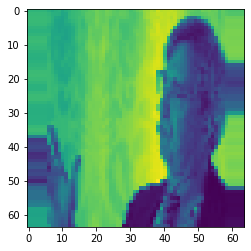

In [222]:
plt.imshow(data_train[0][0][0][...,0])

Processing validation dataset:


In [223]:
datagen_val = ImageDataGenerator(rescale=1./255)

data_val = datagen_val.flow_from_dataframe(dataframe = pd.concat([X_val,y_val],axis=1),
                                           color_mode="grayscale", 
                                           directory=folder, 
                                           target_size=(64, 64),
                                           x_col='filename', 
                                           y_col='category',
                                           class_mode='categorical')

Found 5037 validated image filenames belonging to 3 classes.


# **Setting model**

In [224]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential([
  Conv2D(80, kernel_size=(5,5), strides=(2,2), activation='relu',input_shape=(64, 64, 1)),
  Dropout(0.3),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(40, (5,5), strides=(2,2), activation='relu'),
  Dropout(0.2),
  MaxPooling2D(pool_size=(2,2)),
  Flatten(),
  Dense(10,activation='relu'),
  Dropout(0.1),
  Dense(3, activation='softmax'),
])

In [225]:
from keras.callbacks import ModelCheckpoint

path = '/content/drive/MyDrive/Colab Notebooks/DL/Ex_4/model.h5'
checkpoint = ModelCheckpoint(path, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  


Compiling model:

In [226]:
model.compile(
  optimizer= keras.optimizers.Adam(learning_rate=0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
#fazer testes com poucas épocas para plotar matriz de confusao


# **Fitting and analyzing model**

In [227]:
from tensorflow.keras.utils import to_categorical

start_time = time.time()

history = model.fit(
  data_train,
  epochs=40,
  validation_data = data_val,
  batch_size = 100,
  callbacks = [checkpoint],
  verbose=1
)

print("\n--- %s minutes ---" % (time.time() - start_time))


Epoch 1/40
368/368 [==============================] - ETA: 0s - loss: 1.0564 - accuracy: 0.4280
Epoch 00001: val_loss improved from inf to 1.03208, saving model to /content/drive/MyDrive/Colab Notebooks/DL/Ex_4/model.h5
368/368 [==============================] - 81s 219ms/step - loss: 1.0564 - accuracy: 0.4280 - val_loss: 1.0321 - val_accuracy: 0.4926
Epoch 2/40
368/368 [==============================] - ETA: 0s - loss: 1.0217 - accuracy: 0.4768
Epoch 00002: val_loss improved from 1.03208 to 1.00933, saving model to /content/drive/MyDrive/Colab Notebooks/DL/Ex_4/model.h5
368/368 [==============================] - 80s 217ms/step - loss: 1.0217 - accuracy: 0.4768 - val_loss: 1.0093 - val_accuracy: 0.5063
Epoch 3/40
368/368 [==============================] - ETA: 0s - loss: 0.9872 - accuracy: 0.5126
Epoch 00003: val_loss improved from 1.00933 to 0.98419, saving model to /content/drive/MyDrive/Colab Notebooks/DL/Ex_4/model.h5
368/368 [==============================] - 80s 217ms/step - loss

Plotting train-test accuracy and loss:

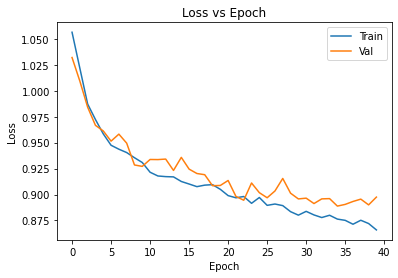

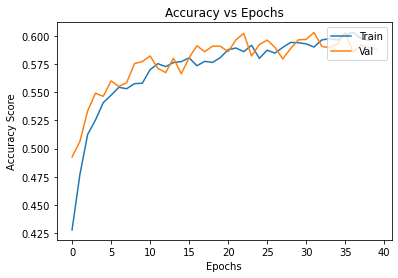

In [238]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

# **Prediction**

Loading model weights:

Setting test dataframe. Not shuffling data and ignoring the labels, shuffle = False and class_mode = None:

In [240]:
data_test = datagen_val.flow_from_dataframe(dataframe = pd.DataFrame(X_test),
                                           color_mode="grayscale", 
                                           directory=folder, 
                                           target_size=(64, 64),
                                           class_mode=None,
                                           classes=None,
                                           batch_size=4198,
                                           shuffle=False)

Found 4198 validated image filenames.


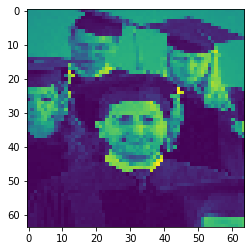

In [241]:
plt.imshow(data_test[0][0][...,0])

Making predictions:

In [242]:
start_time = time.time()

predictions = model.predict(data_test)

print("\n--- %s seconds ---" % (time.time() - start_time))



--- 35.34693384170532 seconds ---


Associating probabilities values with class label:





In [244]:
labels = ['graduation','meeting','picnic']

preds = [labels[i] for i in np.argmax(predictions, axis=-1)]

## **Confusion Matrix**

Defining function to implement confusion matrix:

In [245]:
import seaborn as sns

from sklearn.metrics import confusion_matrix

def c_matrix(y_true,y_pred):
  
  classes = ['graduation','meeting','picnic']

  cm = confusion_matrix(y_true, y_pred)

  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels') 
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes) 
  ax.yaxis.set_ticklabels(classes);



Plotting confustion matrix:

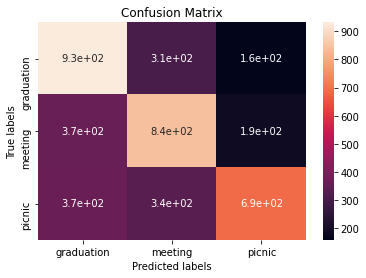

In [249]:

c_matrix(np.array(y_test),np.array(preds))


## **Receiver Operating Characteristic (ROC)**

The Receiver Operating Characteristic (ROC) is obtained by plotting the false positive rate (FPR) vs true positive rate (TPR) of a test.

*   False positive rate:

\begin{equation}
FPR = \frac{FP}{N}
\end{equation}


*   True positive rate:

\begin{equation}
TPR = \frac{TP}{P}
\end{equation}




In [250]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

y = np.array(pd.get_dummies(y_test.copy()))
n_classes = y.shape[1]

y_pred = predictions.copy()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



Plotting ROC curve for each class:

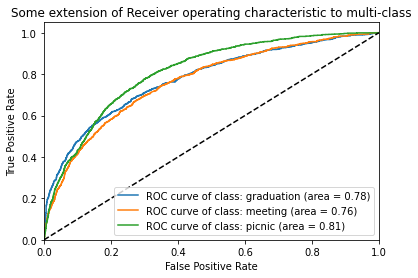

In [251]:
classes = ['graduation', 'meeting', 'picnic']

for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class: {0} (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()